In [1]:
import pandas as pd 
import numpy as np 
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection,naive_bayes,svm
from sklearn.metrics import accuracy_score
import re
import nltk
from sklearn.cluster import KMeans,MiniBatchKMeans,DBSCAN,SpectralClustering,MeanShift
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_samples, silhouette_score
# Classifiers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# utility function for text cleaning and metrics 
from utils import *
from math import log
from sklearn.cluster import KMeans,MiniBatchKMeans,DBSCAN,SpectralClustering,MeanShift
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_samples, silhouette_score
import time
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import roc_auc_score
from scipy.spatial import distance
from sklearn.mixture import GaussianMixture
import seaborn as sns

Using TensorFlow backend.


In [2]:
#Make to function, preprocess, and to calculate cosine similarity
def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    non_word='[^a-zA-Z]'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    parsed_text=re.sub(non_word,' ',parsed_text)
    return parsed_text
#Cosine similarity function
import re, math
from collections import Counter

WORD = re.compile(r'\w+')

def get_cosine(vec1, vec2):
     intersection = set(vec1.keys()) & set(vec2.keys())
     numerator = sum([vec1[x] * vec2[x] for x in intersection])

     sum1 = sum([vec1[x]**2 for x in vec1.keys()])
     sum2 = sum([vec2[x]**2 for x in vec2.keys()])
     denominator = math.sqrt(sum1) * math.sqrt(sum2)

     if not denominator:
        return 0.0
     else:
        return float(numerator) / denominator

def text_to_vector(text):
     words = WORD.findall(text)
     return Counter(words)

#Non Hate Speech 11126
#Hate speech 737


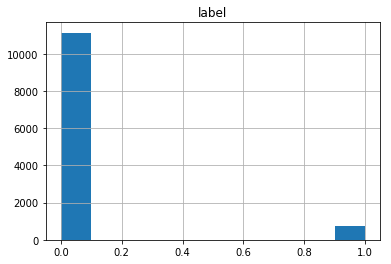

In [3]:

Corpus=pd.read_csv('final_dataset.csv')
#histogram of the label
Corpus.hist(column='label')
Corpus.dropna(inplace=True)
#print the len of hate speech and non hate speech
print("#Non Hate Speech",len(Corpus[Corpus['label']==0]))
print("#Hate speech",len(Corpus[Corpus['label']==1]))

In [4]:
#initialize stop words
stop = stopwords.words('english')
#shuffle the dataset
from sklearn.utils import shuffle
Corpus = shuffle(Corpus)
#remove stopwords before preprocess
Corpus['text'] = Corpus['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#preprocess the text
processed_text=[]
for t in Corpus['text']:
    tokens = preprocess(t)
    processed_text.append(tokens)
Corpus['text']=processed_text

#Split the dataset into Train (10%), Test(20%) and Unlabel (70%)
train=Corpus[:1186]
test=Corpus[1186:2372]
gold_standard=Corpus[2372:]
unlabel=gold_standard.copy()
unlabel.drop(['label'],axis=1,inplace=True)
#train.drop(['text'],axis=1,inplace=True)
#test.drop(['text'],axis=1,inplace=True)
#save the gold standard label
gold_standard.to_csv("result/gold_standard.csv",index=False)
print(len(train))
print(len(test))
print(len(unlabel))


1186
1186
9491


In [5]:
#GMM without balancing
gmean=list()
scoring=list()
auc_score=list()
for iteration in range(0,8):
    print("start ",iteration)
    train_texts = [textTokenizer(text) for text in list(train['text'])]
    train_labels = list(train['label'])
    test_texts = [textTokenizer(text) for text in list(test['text'])]
    test_labels = list(test['label'])
    unlabel_texts = [textTokenizer(text) for text in list(unlabel['text'])]

    #encode the label
    Encoder = LabelEncoder()
    y_train = Encoder.fit_transform(train['label'])
    y_test=Encoder.fit_transform(test['label'])

    #TFIDF vectorizer
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(Corpus['text'])
    Train_X_Tfidf = Tfidf_vect.transform(train_texts)
    Test_X_Tfidf = Tfidf_vect.transform(test_texts)
    Unlabel_X_Tfidf=Tfidf_vect.transform(unlabel_texts)

    #get 10% of unlabeled data
    unlabel_length=round(len(unlabel)*1)
    #Training and predict the label for unlabel dataset, save the low confidence label generated from the entropy
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',probability=True)
    SVM.fit(Train_X_Tfidf,y_train)
    #predict the probability of class
    probs=SVM.predict_proba(Unlabel_X_Tfidf)
    #get the data and then calculate the entropy
    unlabel_pred_data = list()
    for j, text, p in zip(unlabel['index'], list(unlabel['text']), probs):
        unlabel_pred_data.append([j, text, p[0], p[1]])
    unlabel_prob_df = pd.DataFrame(unlabel_pred_data, columns=["index", "text", "class_0", "class_1"])
    entropy=list()
    for p in probs:
        ent=0
        ent1=-p[0] * log(p[0],2)
        ent2=-p[1] * log(p[1],2)
        ent=ent1+ent2
        entropy.append(ent)
    unlabel_prob_df['entropy']=entropy
    #we already have the low entropy
    #get 10% data to be clustered
    unlabel_prob_df=unlabel_prob_df.sort_values(by='entropy',ascending=False)
    #rank the lower uncertainty
    #lower_uncertainty=unlabel_prob_df[unlabel_prob_df['entropy']>=0.5]
    lower_uncertainty=unlabel_prob_df
    low_conf=lower_uncertainty[0:unlabel_length]
    #low_conf=unlabel_prob_df[0:unlabel_length]
    #low_conf=unlabel_prob_df[0:unlabel_length]

    #save the low conf for checking later
    #embedd the low conf text 
    
    #clustering based on uncertainty
    print("clustering ",iteration)
    df=low_conf['entropy']
    uncertain=df.to_numpy()

    #initialize the GMM
    #create the cluster for each low conf data
    gmm = GaussianMixture(n_components=180)
    gmm.fit(uncertain.reshape(-1,1))
    labels=gmm.predict(uncertain.reshape(-1,1))
    similarity_to_center=list()
    for i, instance in enumerate(uncertain.reshape(-1,1)):
        cluster_label = labels[i]
        centroid = gmm.means_[cluster_label] # cluster center of the cluster of that instance

        similarity=distance.euclidean(instance,centroid)
        similarity_to_center.append(similarity)
    cluster_labels=pd.DataFrame({"index":low_conf['index'],"text":low_conf['text'],'cluster':labels,
                                'uncertainty':low_conf['entropy'],'similarity':similarity_to_center})
    #creating cluster_dict
    cluster_dict=dict()
    #creating the dataframe for each cluster
    for item in range(0,180):
        cluster_dict['cluster_{0}'.format(item)]=cluster_labels[cluster_labels['cluster']==item] 
    #Create the dataframe for each cluster
    for i in range(0,180):
            globals()['cluster_{}'.format(i)] = pd.DataFrame(cluster_dict['cluster_{}'.format(i)])
    for i in range(0,180):
        globals()['cluster_{}'.format(i)]=globals()['cluster_{}'.format(i)].sort_values(by="similarity",ascending=True)
    center_data=pd.DataFrame()
    
    for i in range(0,60):
        data1=globals()['cluster_{}'.format(i)]
        mn=data1['similarity'].median()
        first=round(len(data1)*0.05)
        first_data=data1.iloc[first,4]
        second=round(len(data1)*0.95)-1
        second_data=data1.iloc[second,4]
        cntr1=data1[data1['similarity']<=mn]
        ot1=data1[data1['similarity']<=first_data]
        ot2=data1[data1['similarity']<=second_data]
        cntr1=cntr1.head(1)
        ot1=ot1.head(1)
        ot2=ot2.head(1)
        frame=[cntr1,ot1,ot2]
        #data1=globals()['cluster_{}'.format(i)].head(1)
        #data2=globals()['cluster_{}'.format(i)].tail(2)
        #frame=[data1,data2]
        center_data=center_data.append(frame)
    center_data.to_csv("center_data.csv",index=False)


    #labeling
    true_label=pd.read_csv("result/gold_standard.csv")
    #get the label
    new_train=true_label.merge(center_data,on='index',how='left')
    #Drop NaN
    new_train=new_train.dropna()
    #to check the percentage of minority class in each cluster
    #sort by cluster
    new_train.sort_values(by=['cluster'],inplace=True)
    new_train.to_csv("check_minority_class.csv",index=False)
    #Drop duplicate columns
    new_train.drop(['cluster','text_y','similarity'],axis=1,inplace=True)
    new_train.rename(columns={"text_x": "text"},inplace=True)
    #print("Minority Class Captured",len(new_train[new_train['label']==1]))
    #print(len(new_train[new_train['label']==0]))
    #print(len(new_train[new_train['label']==1]))
    #Get 50 of majority and minority class
    training_data=pd.DataFrame({'index':new_train['index'],
                               'label':new_train['label'],'text':new_train['text']})
    print("training data {}".format(len(training_data)))
    #calculating performance

    #train=train.append(training_data)
    train=train.append(training_data)
    print("adding training data {}".format(len(train)))

    train.to_csv("training/training.csv",index=False)
    test.to_csv("training/test.csv",index=False)

    #Drop sample from unlabel pool
    unlabel.to_csv("unlabel.csv",index=False)
    unlabel=unlabel[~unlabel['index'].isin(new_train['index'])]
    print(len(unlabel))
    print("Calculating performance",iteration)

    train=pd.read_csv("training/training.csv")
    test=pd.read_csv("training/test.csv")

    train.dropna(inplace=True)
    test.dropna(inplace=True)

    Encoder = LabelEncoder()
    y_train = Encoder.fit_transform(train['label'])
    y_test = Encoder.fit_transform(test['label'])
    X_train=train['text']
    X_test=test['text']

    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(train['text'])
    Train_X_Tfidf = Tfidf_vect.transform(X_train)
    Test_X_Tfidf = Tfidf_vect.transform(X_test)
    SVM = svm.SVC(C=1, kernel='linear', gamma='auto',probability=True)
    SVM.fit(Train_X_Tfidf,y_train)
    # predict the labels on validation dataset
    predictions_SVM = SVM.predict(Test_X_Tfidf)
    score=geometric_mean_score(y_test, predictions_SVM)
    auc=roc_auc_score(y_test,predictions_SVM)

    print(score)
    scoring.append(score)
    auc_score.append(auc)

print("Finished")

start  0
clustering  0
training data 175
adding training data 1361
9316
Calculating performance 0
0.506409292855323
start  1
clustering  1
training data 174
adding training data 1534
9142
Calculating performance 1
0.5338022645660181
start  2
clustering  2
training data 173
adding training data 1707
8969
Calculating performance 2
0.5335619754408264
start  3
clustering  3
training data 173
adding training data 1880
8796
Calculating performance 3
0.5467383292930292
start  4
clustering  4
training data 174
adding training data 2054
8622
Calculating performance 4
0.5338022645660181
start  5
clustering  5
training data 177
adding training data 2231
8445
Calculating performance 5
0.5469845523765727
start  6
clustering  6
training data 177
adding training data 2408
8268
Calculating performance 6
0.5593523899819391
start  7
clustering  7
training data 177
adding training data 2585
8091
Calculating performance 7
0.546245550166955
Finished


In [6]:
scoring

[0.506409292855323,
 0.5338022645660181,
 0.5335619754408264,
 0.5467383292930292,
 0.5338022645660181,
 0.5469845523765727,
 0.5593523899819391,
 0.546245550166955]